In [18]:
import sys
import os
import tensorflow as tf

# Aggiunge la cartella src al path per poter importare i moduli
sys.path.append(os.path.abspath("src"))

# Autoreload per ricaricare i moduli se li modifichi durante lo sviluppo
%load_ext autoreload
%autoreload 2

# Import dei tuoi moduli custom
from data_loader import QuantumDataManager
from quantum_transformer import QuantumTransformer
from curriculum import CurriculumLearning
from utils import ExperimentManager 

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [19]:
TRANSFORMER_CONFIGS = [
    {
        "name": "transformer_small",
        "window_size": 10,
        "forecast_horizon": 1,
        "embed_dim": 16,
        "num_heads": 2,
        "ff_dim": 32,
        "num_layers": 1,
        "dropout": 0.0,
        "learning_rate": 0.002,
        "batch_size": 64,
        "total_epochs": 8,
        "tf_epochs": 5,
        "mm_epochs": 1,
        "nr_epochs": 2
    },
    {
        "name": "transformer_medium",
        "window_size": 10,
        "forecast_horizon": 1,
        "embed_dim": 64,
        "num_heads": 4,
        "ff_dim": 256,
        "num_layers": 2,
        "dropout": 0.2,
        "learning_rate": 0.0008,
        "batch_size": 64,
        "total_epochs": 12,
        "tf_epochs": 6,
        "mm_epochs": 4,
        "nr_epochs": 2
    },
    {
        "name": "transformer_large",
        "window_size": 15,
        "forecast_horizon": 1,
        "embed_dim": 64,
        "num_heads": 4,
        "ff_dim": 256,
        "num_layers": 2,
        "dropout": 0.2,
        "learning_rate": 0.0005,
        "batch_size": 64,
        "total_epochs": 12,
        "tf_epochs": 5,
        "mm_epochs": 5,
        "nr_epochs": 2
    }
]

In [20]:
def train_with_curriculum(
    model,
    train_ds,
    val_ds,
    optimizer,
    loss_fn,
    epochs,
    tf_epochs=5,
    mm_epochs=8,
    nr_epochs=2,
):
    curriculum = CurriculumLearning(model, optimizer, loss_fn)

    history = {
        "loss": [],
        "val_loss": [],
        "phase": []
    }

    total_epochs = tf_epochs + mm_epochs + nr_epochs
    assert epochs == total_epochs

    for epoch in range(epochs):
        # --- 1. Determina la fase ---
        if epoch < tf_epochs:
            phase = "teacher_forcing"
        elif epoch < tf_epochs + mm_epochs:
            phase = "masked_modeling"
        else:
            phase = "noise_robustness"

        # --- 2. Training Loop ---
        epoch_loss = tf.keras.metrics.Mean()
        
        for x, y in train_ds:
            if phase == "teacher_forcing":
                loss = curriculum.teacher_forcing_step(x, y)
            elif phase == "masked_modeling":
                loss = curriculum.masked_modeling_step(x, y)
            else:
                loss = curriculum.noise_robustness_step(x, y)
            
            epoch_loss.update_state(loss)

        # --- 3. Validation Loop (NUOVO) ---
        # Calcoliamo la loss sul validation set (in modalità Teacher Forcing standard)
        val_loss_metric = tf.keras.metrics.Mean()
        for x_val, y_val in val_ds:
            preds = model(encoder_input=x_val, decoder_input=y_val, training=False)
            v_loss = loss_fn(y_val, preds)
            val_loss_metric.update_state(v_loss)

        # --- 4. Logging ---
        train_l = epoch_loss.result().numpy()
        val_l = val_loss_metric.result().numpy()
        
        history["loss"].append(train_l)
        history["val_loss"].append(val_l)
        history["phase"].append(phase)

        print(f"Epoch {epoch+1:03d} | {phase[:15]:15s} | Train Loss: {train_l:.5f} | Val Loss: {val_l:.5f}")

    return history


--- Avvio Esperimento: transformer_large ---
Dataset caricato: (250000, 56)
Traiettorie individuate: 250
[transformer_large] Dataset caricato. Train shape: (196950, 15, 55)
Dati caricati. Input features: 55


c:\Users\aldog\miniconda3\envs\DeepProject\Lib\site-packages\keras\src\ops\nn.py:947: UserWarning: You are using a softmax over axis 3 of a tensor of shape (64, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\aldog\miniconda3\envs\DeepProject\Lib\site-packages\keras\src\ops\nn.py:947: UserWarning: You are using a softmax over axis 3 of a tensor of shape (None, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(
c:\Users\aldog\miniconda3\envs\DeepProject\Lib\site-packages\keras\src\ops\nn.py:947: UserWarning: You are using a softmax over axis 3 of a tensor of shape (20, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoi

Epoch 001 | teacher_forcing | Train Loss: 0.01077 | Val Loss: 0.00153
Epoch 002 | teacher_forcing | Train Loss: 0.00065 | Val Loss: 0.00046
Epoch 003 | teacher_forcing | Train Loss: 0.00029 | Val Loss: 0.00027
Epoch 004 | teacher_forcing | Train Loss: 0.00019 | Val Loss: 0.00021
Epoch 005 | teacher_forcing | Train Loss: 0.00014 | Val Loss: 0.00017
Epoch 006 | masked_modeling | Train Loss: 0.00033 | Val Loss: 0.00028
Epoch 007 | masked_modeling | Train Loss: 0.00012 | Val Loss: 0.00015
Epoch 008 | masked_modeling | Train Loss: 0.00010 | Val Loss: 0.00014
Epoch 009 | masked_modeling | Train Loss: 0.00008 | Val Loss: 0.00012
Epoch 010 | masked_modeling | Train Loss: 0.00007 | Val Loss: 0.00010
Epoch 011 | noise_robustnes | Train Loss: 0.00012 | Val Loss: 0.00017
Epoch 012 | noise_robustnes | Train Loss: 0.00011 | Val Loss: 0.00016

--- Salvataggio Risultati ---
Pesi salvati in: data\weights\transformer_large.weights.h5
History salvata in: data\history\transformer_large_history.csv

--- Ge

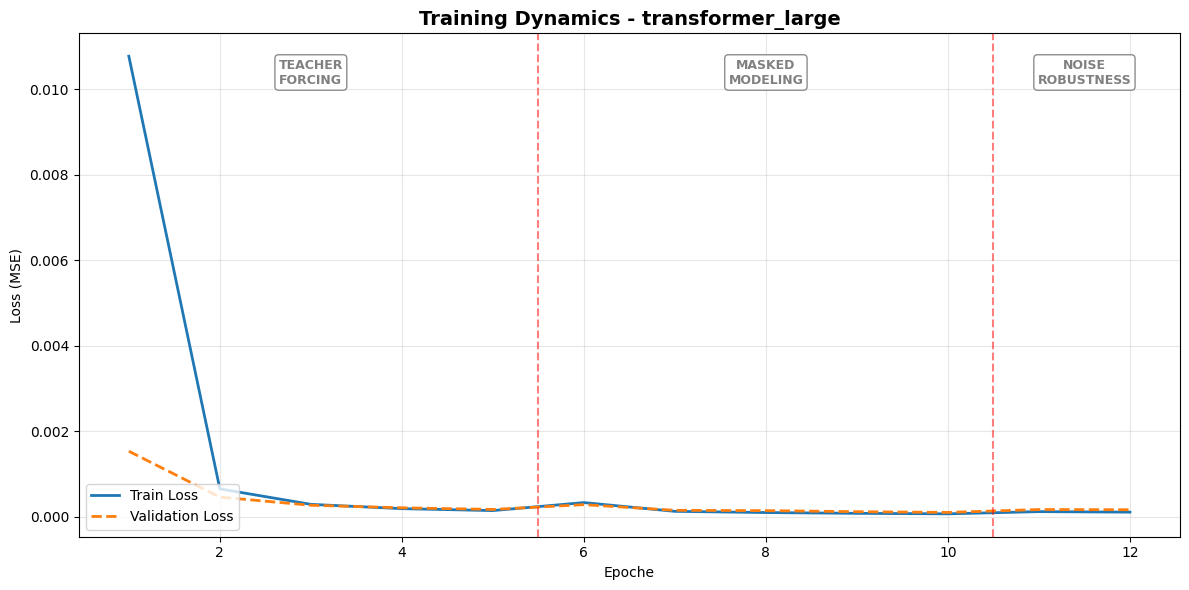

Grafico salvato in: data\plots\transformer_large_detailed_loss.png
Generazione predizioni per 1000 step...


c:\Users\aldog\miniconda3\envs\DeepProject\Lib\site-packages\keras\src\ops\nn.py:947: UserWarning: You are using a softmax over axis 3 of a tensor of shape (1000, 4, 1, 1). This axis has size 1. The softmax operation will always return the value 1, which is likely not what you intended. Did you mean to use a sigmoid instead?
  warnings.warn(


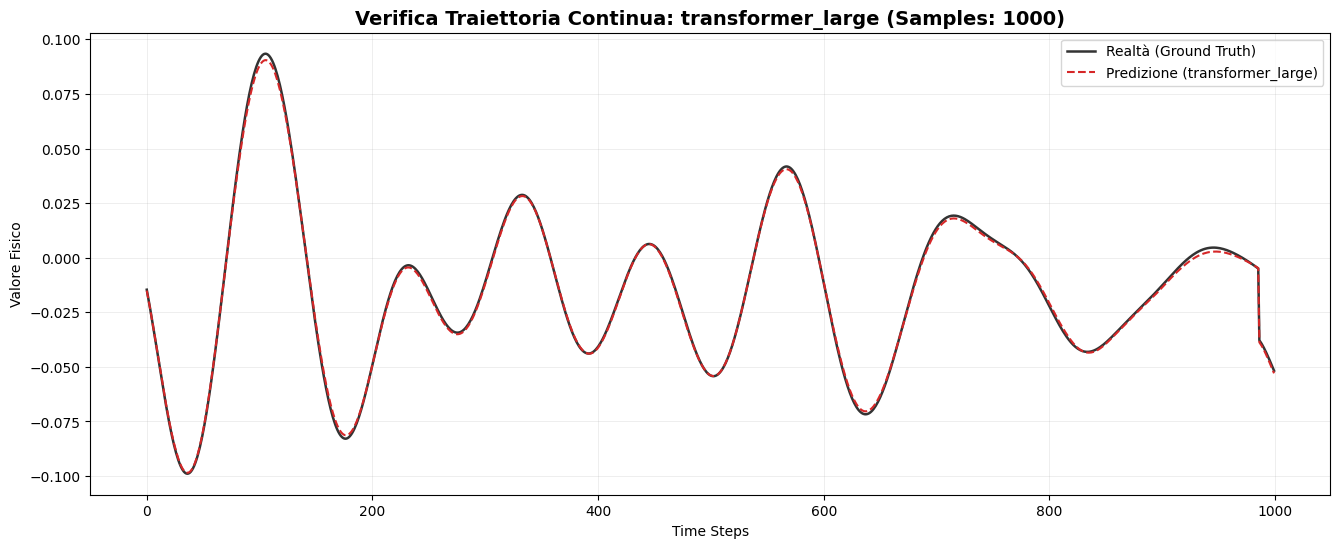

Grafico salvato in: data\plots\transformer_large_continuous_traj.png


'for transformer_config in TRANSFORMER_CONFIGS:\n    run_curriculum_experiment(transformer_config)'

In [21]:
# Inizializza il manager
exp_manager = ExperimentManager(base_path="data")

def run_curriculum_experiment(config):
    print(f"\n--- Avvio Esperimento: {config['name']} ---")
    
    # 1. Caricamento Dati
    dm = QuantumDataManager(config)
    
    # Assicurati che i dati siano caricati per accedere a X_train
    if not hasattr(dm, 'X_train'):
        dm.load_and_process(num_rows=250000)

    # Leggi la dim da Numpy invece che dal Dataset ---
    input_dim = dm.X_train.shape[-1] 

    # Ora crea i dataset con cache attiva
    train_ds, val_ds = dm.get_tf_datasets()
    
    print(f"Dati caricati. Input features: {input_dim}")

    # 2. Modello
    model = QuantumTransformer(
        input_dim=input_dim,
        seq_len=config['window_size'],
        d_model=config['embed_dim'],
        num_heads=config['num_heads'],
        d_ff=config['ff_dim'],
        num_layers=config['num_layers'],
        dropout=config['dropout']
    )

    optimizer = tf.keras.optimizers.Adam(learning_rate=config['learning_rate'])
    loss_fn = tf.keras.losses.MeanSquaredError()

    # 3. Training
    history = train_with_curriculum(
        model=model,
        train_ds=train_ds,
        val_ds=val_ds,
        optimizer=optimizer,
        loss_fn=loss_fn,
        epochs=config['total_epochs'],
        tf_epochs=config['tf_epochs'],
        mm_epochs=config['mm_epochs'],
        nr_epochs=config['nr_epochs']
    )
    
    # 4. Salvataggio e Plotting (tramite la classe ExperimentManager)
    print("\n--- Salvataggio Risultati ---")
    exp_manager.save_model_artifacts(model, history, config['name'])
    
    print("\n--- Generazione Grafici ---")
    exp_manager.plot_training_phases_detailed(history, config['name'])
    exp_manager.plot_trajectory_check(model, dm, config['name'])
    
    return model, history

# Esecuzione
run_curriculum_experiment(TRANSFORMER_CONFIGS[2])
'''for transformer_config in TRANSFORMER_CONFIGS:
    run_curriculum_experiment(transformer_config)'''

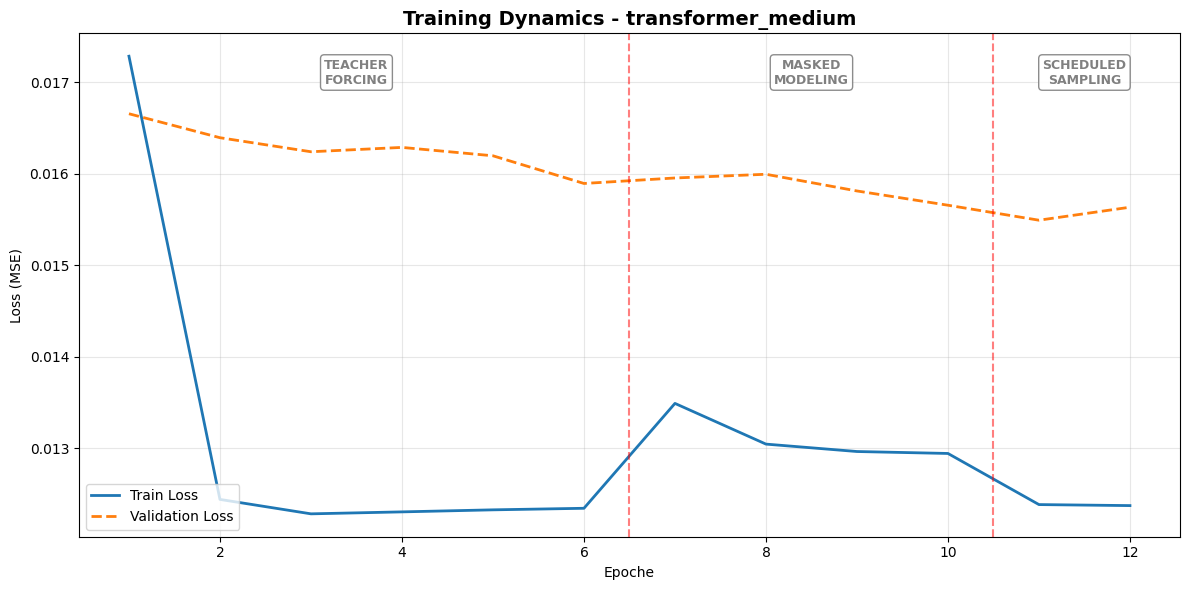

Grafico salvato in: data\plots\transformer_medium_detailed_loss.png


"dm = QuantumDataManager(config)\ndm.load_and_process() # Carica i dati per avere X_test e lo scaler\ninput_dim = dm.X_train.shape[-1]\n\nmodel = QuantumTransformer(\n    input_dim=input_dim,\n    seq_len=config['window_size'],\n    d_model=config['embed_dim'],\n    num_heads=config['num_heads'],\n    d_ff=config['ff_dim'],\n    num_layers=config['num_layers'],\n    dropout=config['dropout']\n)\n\n# 5. Carica Pesi\nexp_manager.load_model_weights(model, config['name'])\n\n# 6. Plot Traiettoria\nexp_manager.plot_trajectory_check(model, dm, config['name'])"

In [22]:
import pandas as pd

# 1. Configurazione
config = TRANSFORMER_CONFIGS[1] # Assicurati sia la stessa usata per il training
exp_manager = ExperimentManager()

# 2. Carica History
history_df = pd.read_csv(f"data/history/{config['name']}_history.csv")
# Converti in dict per la funzione plot
history_dict = history_df.to_dict(orient='list')

# 3. Plot History
exp_manager.plot_training_phases_detailed(history_dict, config['name'])

# 4. Inizializza Data Manager e Modello (necessari per la traiettoria)
'''dm = QuantumDataManager(config)
dm.load_and_process() # Carica i dati per avere X_test e lo scaler
input_dim = dm.X_train.shape[-1]

model = QuantumTransformer(
    input_dim=input_dim,
    seq_len=config['window_size'],
    d_model=config['embed_dim'],
    num_heads=config['num_heads'],
    d_ff=config['ff_dim'],
    num_layers=config['num_layers'],
    dropout=config['dropout']
)

# 5. Carica Pesi
exp_manager.load_model_weights(model, config['name'])

# 6. Plot Traiettoria
exp_manager.plot_trajectory_check(model, dm, config['name'])'''